# Crop Yield Prediction: PyTorch Neural Network with Optuna (Part 5)

## Overview
This notebook trains a **Feedforward Neural Network (PyTorch)** model to predict crop yields. You can configure the specific target crop in the data loading section.

## Methodology
1.  **Crop Selection:** Choose the specific crop to predict.
2.  **Feature Analysis:** Review the input variables.
3.  **Time-Series Split:** Divide data by year to ensure we don't predict the past using the future:
    * **Train:** Learn patterns.
    * **Validation:** Tune settings.
    * **Test:** Final evaluation.
4.  **Data Scaling:** Normalize features for Neural Network stability.
5.  **Baseline:** Compare against a simple guess (Last Year's Yield).
6.  **Initial Model:** Train a default NN model and check learning curves for errors.
7.  **Optimization:** Use **Optuna** to automatically find the best network architecture and hyperparameters.
8.  **Final Evaluation:** Compare accuracy (RMSE) across all stages.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

C:\Users\PavinP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


### 1. Data Preparation and Crop Choice
We load the main dataset and identify the available crops. For this analysis, we focus specifically on **Rice**. We clean the data by removing columns related to other crops and deleting any rows where the target yield information is missing.

In [2]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v2.parquet')

# --- LIST AVAILABLE CROPS ---
# Assumes targets start with 'Y_'
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("--- Available Crops found in Dataset ---")
print(available_crops)
print("-" * 40)

# --- CONFIGURATION: SET CROP HERE ---
CHOSEN_CROP = 'rice'  # <--- CHANGE THIS to 'lettuce', 'pepper', etc. based on list above
# ------------------------------------

# Define Target and Dynamic Lag Features
TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y'

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found in dataset. Check spelling.")

print(f"Predicting Target: {TARGET_COL}")
print(f"Using Lag 1 Feature: {LAG_1_FEATURE}")

# Clean Missing Targets for the chosen crop
df_model = df.dropna(subset=[TARGET_COL])

print(f"Data Loaded. Rows with valid target: {len(df_model)}")

--- Available Crops found in Dataset ---
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Predicting Target: Y_rice
Using Lag 1 Feature: avg_yield_rice_1y
Data Loaded. Rows with valid target: 4729


### 2. Selecting Features, Splitting, and Scaling Data
We identify the input variables. We split data by year to avoid data leakage. **Crucially**, for Neural Networks, we must scale the data (StandardScaler) so that all features have a mean of 0 and variance of 1, preventing gradient instability.

In [3]:
# --- IMPORTS (Add these if not already present) ---
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd

# --- DROP UNWANTED COLUMNS ---
# Drop all columns that start with "avg_yield_" but do NOT match the chosen crop
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]

df_model = df_model.drop(columns=cols_to_drop)

# --- FEATURE SELECTION ---
# Select independent variables (exclude 'Y_' columns and metadata)
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

# --- DISPLAY FEATURES TABLE ---
print(f"Total Features Used: {len(feature_cols)}")
print("-" * 30)
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# 1. Training Set (< 2014)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train_raw = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# 2. Validation Set (>= 2014 and < 2019)
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val_raw = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# 3. Test Set (>= 2019)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test_raw = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

# --- IMPUTATION (Handle NaNs before scaling) ---
imputer = SimpleImputer(strategy='mean')  # Or 'median' if data is skewed
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_raw), columns=feature_cols)
X_val_imputed = pd.DataFrame(imputer.transform(X_val_raw), columns=feature_cols)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_raw), columns=feature_cols)

# Optional: Print NaN counts to verify (should be 0 after imputation)
print("NaNs in X_train_imputed:", X_train_imputed.isnull().sum().sum())
print("NaNs in X_val_imputed:", X_val_imputed.isnull().sum().sum())
print("NaNs in X_test_imputed:", X_test_imputed.isnull().sum().sum())

# --- SCALING (Required for Neural Networks) ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_imputed)
X_val = scaler.transform(X_val_imputed)
X_test = scaler.transform(X_test_imputed)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

print(f"\nTraining Samples   (<{TRAIN_END_YEAR})     : {len(X_train)}")
print(f"Validation Samples ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1}): {len(X_val)}")
print(f"Testing Samples    (>={VAL_END_YEAR})    : {len(X_test)}")


Total Features Used: 23
------------------------------


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
Feature Name,year,avg_yield_rice_1y,avg_yield_rice_3y,avg_yield_rice_5y,sum_rain_winter,sum_rain_spring,sum_rain_summer,sum_rain_autumn,sum_rain_annual,avg_solar_winter,...,avg_solar_annual,avg_temp_winter,avg_temp_spring,avg_temp_summer,avg_temp_autumn,avg_temp_annual,pesticides_lag1,fertilizer_lag1,latitude,longitude


NaNs in X_train_imputed: 0
NaNs in X_val_imputed: 0
NaNs in X_test_imputed: 0

Training Samples   (<2014)     : 3579
Validation Samples (2014-2018): 575
Testing Samples    (>=2019)    : 575


### 3. Setting a Baseline
Before using complex AI, we create a simple baseline to measure success. We assume that the yield this year will be exactly the same as last year. We calculate the error (RMSE) of this simple guess to establish a score we must beat.

In [4]:
# Baseline: yield(t) = yield(t-1)
# Note: We use the raw dataframe for baseline lag feature access
y_pred_baseline = df_model[mask_test][LAG_1_FEATURE]

# Clean NaNs for metric calculation
mask_valid = ~y_pred_baseline.isna() & ~y_test.isna()
y_test_clean = y_test[mask_valid]
y_pred_clean = y_pred_baseline[mask_valid]

rmse_baseline = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
r2_baseline = r2_score(y_test_clean, y_pred_clean)

print(f"Baseline RMSE: {rmse_baseline:.2f}")

Baseline RMSE: 533.44


### 4. Initial Model Testing
We train a basic Feedforward Neural Network using standard settings. We plot the training vs validation loss to check for overfitting or underfitting.

Epoch 0/150 | Train RMSE: 3839.40 | Val RMSE: 4580.31
Epoch 20/150 | Train RMSE: 787.99 | Val RMSE: 780.91
Epoch 40/150 | Train RMSE: 597.47 | Val RMSE: 588.43
Epoch 60/150 | Train RMSE: 558.41 | Val RMSE: 545.24
Epoch 80/150 | Train RMSE: 543.99 | Val RMSE: 538.08
Epoch 100/150 | Train RMSE: 541.80 | Val RMSE: 518.63
Epoch 120/150 | Train RMSE: 536.81 | Val RMSE: 521.70
Epoch 140/150 | Train RMSE: 539.03 | Val RMSE: 518.50
Epoch 149/150 | Train RMSE: 533.11 | Val RMSE: 523.14


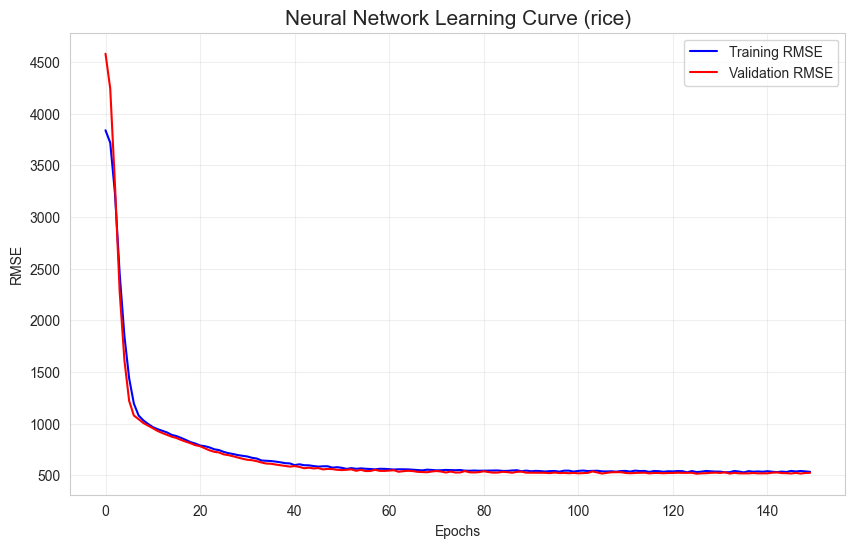

Initial Model Test RMSE: 512.51


In [5]:
# --- DEFINE NEURAL NETWORK STRUCTURE ---
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

# --- TRAINING HELPER FUNCTION ---
def train_model(model, X_t, y_t, X_v, y_v, lr=0.001, epochs=150, batch_size=32, verbose=True):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=True)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
            
        # Calculate average losses (RMSE representation)
        train_mse = epoch_loss / len(X_t)
        train_rmse = np.sqrt(train_mse)
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_v)
            val_loss = criterion(val_outputs, y_v)
            val_rmse = np.sqrt(val_loss.item())
            
        train_losses.append(train_rmse)
        val_losses.append(val_rmse)
        
        if verbose and (epoch % 20 == 0 or epoch == epochs-1):
            print(f"Epoch {epoch}/{epochs} | Train RMSE: {train_rmse:.2f} | Val RMSE: {val_rmse:.2f}")
            
    return train_losses, val_losses

# --- INITIAL MODEL TRAINING ---
input_dim = X_train.shape[1]
model_init = SimpleNN(input_dim).to(device)

train_hist, val_hist = train_model(model_init, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

# --- PLOT LEARNING CURVE ---
plt.figure(figsize=(10, 6))
plt.plot(train_hist, label='Training RMSE', color='blue')
plt.plot(val_hist, label='Validation RMSE', color='red')
plt.title(f'Neural Network Learning Curve ({CHOSEN_CROP})', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate on TEST Set
model_init.eval()
with torch.no_grad():
    y_pred_init_test = model_init(X_test_tensor).cpu().numpy().flatten()

rmse_init_test = np.sqrt(mean_squared_error(y_test, y_pred_init_test))
r2_init_test = r2_score(y_test, y_pred_init_test)

print(f"Initial Model Test RMSE: {rmse_init_test:.2f}")

### 5. Tuning the Model (Optuna)
To improve performance, we use **Optuna** to find the best neural network architecture. We run trials adjusting hidden layers, units, dropout rate, learning rate, and batch size.

In [6]:
# --- DYNAMIC NN BUILDER ---
class DynamicNN(nn.Module):
    def __init__(self, input_dim, n_layers, n_units, dropout, activation_name):
        super(DynamicNN, self).__init__()
        layers = []
        in_features = input_dim
        
        # Choose Activation Function
        if activation_name == "ReLU":
            activation = nn.ReLU()
        elif activation_name == "LeakyReLU":
            activation = nn.LeakyReLU()
        else:
            activation = nn.Tanh()

        # Build Hidden Layers
        for _ in range(n_layers):
            layers.append(nn.Linear(in_features, n_units))
            layers.append(activation)
            layers.append(nn.Dropout(dropout))
            in_features = n_units
            
        # Output Layer
        layers.append(nn.Linear(in_features, 1))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- OPTUNA OBJECTIVE FUNCTION ---
def objective(trial):
    # Hyperparameters
    n_layers = trial.suggest_int("n_layers", 2, 4)
    n_units = trial.suggest_int("n_units", 16, 64)
    dropout = trial.suggest_float("dropout", 0.1, 0.2)
    lr = trial.suggest_float("lr", 5e-4, 1.5e-3)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "Tanh"])

    # Build model on device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DynamicNN(X_train.shape[1], n_layers, n_units, dropout, activation).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # DataLoader
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)),
                              batch_size=batch_size, shuffle=True)

    # Train fewer epochs during tuning
    epochs = 30
    model.train()
    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(batch_x), batch_y)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        X_val = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_pred = model(X_val).cpu().numpy()
        val_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return val_rmse


# --- RUN OPTIMIZATION ---
study_name = f'{CHOSEN_CROP.capitalize()}_Yield_NN'
study = optuna.create_study(direction='minimize', study_name=study_name)
study.optimize(objective, n_trials=20)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-11-29 16:16:53,065] A new study created in memory with name: Rice_Yield_NN
[I 2025-11-29 16:16:54,477] Trial 0 finished with value: 1096.9757809848172 and parameters: {'n_layers': 2, 'n_units': 38, 'dropout': 0.16003338623719648, 'lr': 0.0005917696611862755, 'batch_size': 64, 'activation': 'ReLU'}. Best is trial 0 with value: 1096.9757809848172.
[I 2025-11-29 16:16:58,355] Trial 1 finished with value: 556.3824441191224 and parameters: {'n_layers': 3, 'n_units': 48, 'dropout': 0.12388493699562995, 'lr': 0.0010894992153811075, 'batch_size': 32, 'activation': 'LeakyReLU'}. Best is trial 1 with value: 556.3824441191224.
[I 2025-11-29 16:17:00,552] Trial 2 finished with value: 575.7259589769162 and parameters: {'n_layers': 4, 'n_units': 43, 'dropout': 0.12849795430949557, 'lr': 0.0014902096629616308, 'batch_size': 64, 'activation': 'LeakyReLU'}. Best is trial 1 with value: 556.3824441191224.
[I 2025-11-29 16:17:01,954] Trial 3 finished with value: 1275.409811829077 and parameters: {


Best Parameters found:
{'n_layers': 3, 'n_units': 54, 'dropout': 0.1603955409818773, 'lr': 0.0009332532038145822, 'batch_size': 16, 'activation': 'LeakyReLU'}


### 6. Visualizing Optimization
We generate charts to understand the tuning process. These visual tools show us which specific settings had the biggest impact on reducing the model's error.

In [7]:
# --- OPTUNA VISUALIZATIONS ---
name = f"{CHOSEN_CROP.capitalize()}_Yield_NN"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 7. Final Model Training
Using the best settings found during the tuning phase, we build the final neural network. We train this model on both the Training and Validation data combined to maximize learning.

In [9]:
# 1. Combine Train + Validation
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))

X_train_full_tensor = torch.tensor(X_train_full, dtype=torch.float32).to(device)
y_train_full_tensor = torch.tensor(y_train_full, dtype=torch.float32).view(-1, 1).to(device)

# 2. Retrieve Best Params
bp = study.best_params

# 3. Initialize Model
final_model = DynamicNN(
    input_dim=X_train.shape[1],
    n_layers=bp['n_layers'],
    n_units=bp['n_units'],
    dropout=bp['dropout'],
    activation_name=bp['activation']
).to(device)

# 4. Optimizer
optimizer = optim.Adam(final_model.parameters(), lr=bp['lr'])

# 5. Loss + DataLoader
criterion = nn.MSELoss()
train_loader = DataLoader(TensorDataset(X_train_full_tensor, y_train_full_tensor), 
                          batch_size=bp['batch_size'], shuffle=True)

# 6. Train Final Model
final_model.train()
for epoch in range(150):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        loss = criterion(final_model(batch_X), batch_y)
        loss.backward()
        optimizer.step()

# 7. Evaluate on Test
final_model.eval()
with torch.no_grad():
    y_pred_final_test = final_model(X_test_tensor).cpu().numpy().flatten()

rmse_final_test = np.sqrt(mean_squared_error(y_test, y_pred_final_test))
r2_final_test = r2_score(y_test, y_pred_final_test)
print(f"Final Test RMSE: {rmse_final_test:.3f}, R2: {r2_final_test:.3f}")


Final Test RMSE: 523.285, R2: 0.945


### 8. Results and Analysis
We evaluate the final performance on the Test data (2019–2023).
* **Comparison:** We check if the Tuned Model beats the Baseline and the Initial Model.
* **Trend Analysis:** We plot the predicted yields against actual yields over time.

--- Final Performance Report (Test Set) ---
Baseline Model: RMSE=533.44, R2=0.9427
Initial Model:  RMSE=512.51, R2=0.9472
Tuned NN Model: RMSE=523.28, R2=0.9449 (RMSE Improved 1.90%)


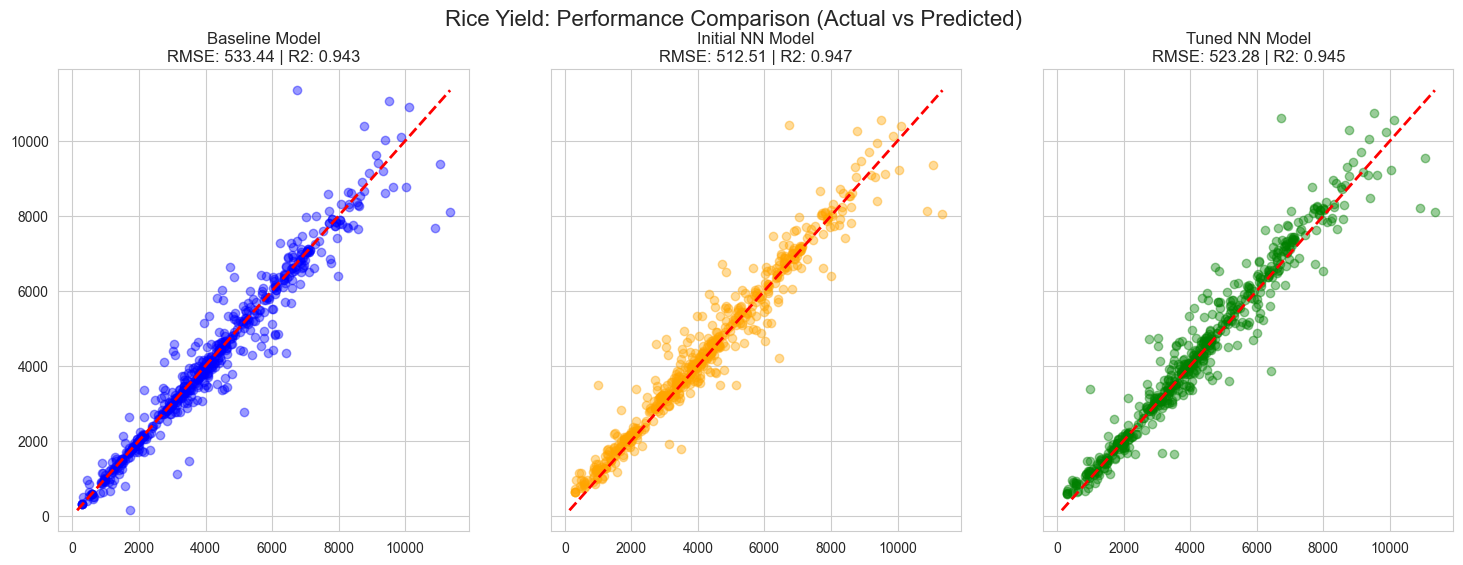

In [10]:
# Calculate Improvement %
imp_final = (rmse_baseline - rmse_final_test) / rmse_baseline * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Baseline Model: RMSE={rmse_baseline:.2f}, R2={r2_baseline:.4f}")
print(f"Initial Model:  RMSE={rmse_init_test:.2f}, R2={r2_init_test:.4f}")
print(f"Tuned NN Model: RMSE={rmse_final_test:.2f}, R2={r2_final_test:.4f} (RMSE Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Axis Limits
all_preds = np.concatenate([y_pred_clean, y_pred_init_test, y_pred_final_test])
all_true = np.concatenate([y_test_clean, y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# 1. Baseline Plot
axes[0].scatter(y_test_clean, y_pred_clean, alpha=0.4, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Baseline Model\nRMSE: {rmse_baseline:.2f} | R2: {r2_baseline:.3f}')

# 2. Initial Model Plot
axes[1].scatter(y_test, y_pred_init_test, alpha=0.4, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Initial NN Model\nRMSE: {rmse_init_test:.2f} | R2: {r2_init_test:.3f}')

# 3. Tuned Model Plot
axes[2].scatter(y_test, y_pred_final_test, alpha=0.4, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[2].set_title(f'Tuned NN Model\nRMSE: {rmse_final_test:.2f} | R2: {r2_final_test:.3f}')

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Performance Comparison (Actual vs Predicted)', fontsize=16)
plt.show()

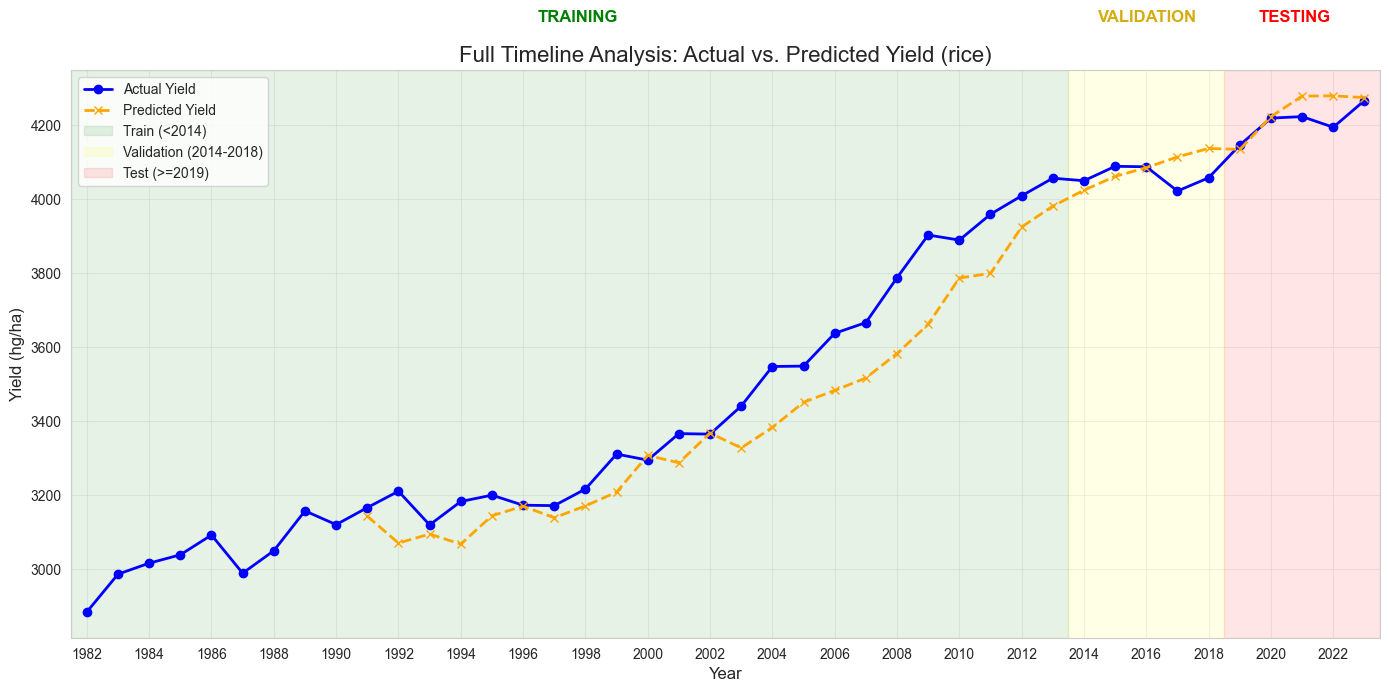

In [11]:
# --- FULL TIMELINE PLOT ---
import matplotlib.pyplot as plt

# 1. Generate Predictions for all data (scaled)
# Note: Using the scaler fit on training data for consistency
X_all_scaled = scaler.transform(df_model[feature_cols])
X_all_tensor = torch.tensor(X_all_scaled, dtype=torch.float32).to(device)

final_model.eval()
with torch.no_grad():
    all_predictions = final_model(X_all_tensor).cpu().numpy().flatten()

# 2. Create DataFrame
df_full_trend = pd.DataFrame({
    'Year': df_model['year'],
    'Actual': df_model[TARGET_COL],
    'Predicted': all_predictions
})

# Aggregate by Year
yearly_trend = df_full_trend.groupby('Year').mean()

# 3. Plotting
plt.figure(figsize=(14, 7))

# Plot Lines
plt.plot(yearly_trend.index, yearly_trend['Actual'], 
         marker='o', label='Actual Yield', linewidth=2, color='blue')
plt.plot(yearly_trend.index, yearly_trend['Predicted'], 
         marker='x', linestyle='--', label='Predicted Yield', linewidth=2, color='orange')

# Define Split Boundaries
MIN_YEAR = yearly_trend.index.min()
MAX_YEAR = yearly_trend.index.max()
train_boundary = TRAIN_END_YEAR - 0.5
val_boundary = VAL_END_YEAR - 0.5

# --- Highlight Periods ---
plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1, label=f'Train (<{TRAIN_END_YEAR})')
plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1, label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1})')
plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1, label=f'Test (>={VAL_END_YEAR})')

# Add Text Labels
y_max = yearly_trend['Actual'].max()
text_y = y_max * 1.05 

plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING', ha='center', fontsize=12, fontweight='bold', color='green')
plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION', ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')
plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING', ha='center', fontsize=12, fontweight='bold', color='red')

# Final Formatting
plt.title(f'Full Timeline Analysis: Actual vs. Predicted Yield ({CHOSEN_CROP})', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Yield (hg/ha)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(MIN_YEAR, MAX_YEAR + 1, 2))
plt.xlim(MIN_YEAR - 0.5, MAX_YEAR + 0.5)

plt.tight_layout()
plt.show()

* **Geographic Error:** We map the error rates by country to see where the model performs best and where it struggles.

In [ ]:
# --- RE-CREATE COMPARISON DF WITH FEATURE JOINED ---
# We need the original 'area' column from the test set for joining
mask_test = df_model['year'] >= VAL_END_YEAR
test_set_context = df_model[mask_test][['area', 'year']] 

comparison_df = pd.DataFrame({
    'Actual_Value': y_test,
    'Predicted_Value': y_pred_final_test
})

# Join works automatically because y_test retained index from original df_model
comparison_df = comparison_df.join(test_set_context)
comparison_df = comparison_df[['year', 'area', 'Actual_Value', 'Predicted_Value']]

print("--- Actual vs. Predicted Test Set Results ---")
print(comparison_df.head())

In [ ]:
import plotly.express as px

# Name Cleaning for Map Plotting
comparison_df['area'] = comparison_df['area'].replace({
    'United_States_of_America': 'United States',
    'United_Kingdom_of_Great_Britain_and_Northern_Ireland': 'United Kingdom',
    'Russian_Federation': 'Russia',
    'Viet_Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'Bolivia_(Plurinational_State_of)': 'Bolivia',
    'Iran_(Islamic_Republic_of)': 'Iran',
    "Lao_People's_Democratic_Republic": 'Laos',
    'China,_mainland': 'China',
    'China,_Taiwan_Province_of': 'Taiwan',
    "Democratic_People's_Republic_of_Korea": 'North Korea',
    'Republic_of_Korea': 'South Korea',
    'Côte_d\'Ivoire': "Cote d'Ivoire",
    'United_Republic_of_Tanzania': 'Tanzania',
    'Micronesia_(Federated_States_of)': 'Micronesia',
    'Venezuela_(Bolivarian_Republic_of)': 'Venezuela'
})

def plot_geographic_error(comparison_df):
    # Squared Error (for RMSE)
    comparison_df['Squared_Error'] = (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) ** 2
    # Squared Percentage Error (for RMSPE)
    epsilon = 1e-6 
    comparison_df['Squared_Percentage_Error'] = (
        (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) / 
        (comparison_df['Actual_Value'] + epsilon)
    ) ** 2

    # Aggregate Errors by Country
    rmse_df = (
        comparison_df.groupby('area')['Squared_Error']
        .mean().apply(np.sqrt).reset_index()
        .rename(columns={'area': 'Country', 'Squared_Error': 'RMSE'})
    )
    rmspe_df = (
        comparison_df.groupby('area')['Squared_Percentage_Error']
        .mean().apply(np.sqrt).multiply(100).reset_index()
        .rename(columns={'area': 'Country', 'Squared_Percentage_Error': 'RMSPE'})
    )
    ap_df = comparison_df.groupby('area')[['Actual_Value', 'Predicted_Value']].mean().reset_index()
    ap_df = ap_df.rename(columns={'area': 'Country'})

    # Merge stats
    error_stats = rmspe_df.merge(rmse_df, on='Country', how='left')
    error_stats = error_stats.merge(ap_df, on='Country', how='left') 

    # Plot
    fig = px.choropleth(
        error_stats,
        locations='Country',
        color='RMSPE',
        locationmode='country names',
        color_continuous_scale=['green', 'red'], 
        range_color=[0, 50], 
        title='Geographic Distribution of Prediction Error (RMSPE)',
        labels={'RMSPE': 'RMSPE (%)'},
        hover_name='Country',
        hover_data={'RMSPE': ':.2f', 'RMSE': ':.2f', 'Actual_Value': ':.2f', 'Predicted_Value': ':.2f'},
        projection='natural earth'
    )
    fig.update_layout(
        title_font_size=18,
        coloraxis_colorbar=dict(title='RMSPE (%)', orientation='h', len=0.5, yanchor='bottom', y=-0.12),
        geo=dict(showframe=False, showcoastlines=True, showcountries=True, countrycolor='black', bgcolor='lightgrey')
    )
    fig.show()

plot_geographic_error(comparison_df)

### 9. Key Factors (Feature Importance)
Unlike Decision Trees, Neural Networks don't have a built-in feature importance metric. To estimate this, we use **Permutation Importance**: we randomly shuffle one feature column at a time and measure how much the prediction error increases. A large increase means that feature was important.

In [ ]:
# --- WRAPPER FOR SKLEARN COMPATIBILITY ---
class PyTorchEstimator:
    """Wrapper to make PyTorch model behave like a Sklearn estimator for permutation_importance"""
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def fit(self, X, y):
        pass # Model is already trained

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            preds = self.model(X_tensor).cpu().numpy().flatten()
        return preds

# --- CALCULATE PERMUTATION IMPORTANCE ---
# Using validation set to gauge importance generalization
wrapped_model = PyTorchEstimator(final_model, device)
results = permutation_importance(wrapped_model, X_val, y_val, scoring='neg_root_mean_squared_error', n_repeats=5, random_state=42)

# --- PROCESS RESULTS ---
# Note: permutation_importance returns negative RMSE changes for 'neg_root...', 
# so lower (more negative) is worse performance when shuffled -> higher importance.
# We take absolute value of the mean importances to show magnitude of impact.
importance_means = np.abs(results.importances_mean)
feature_names = np.array(feature_cols)

# Create DataFrame
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_means
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print Top 20
print("\n--- Top 20 Most Important Features (Permutation Importance) ---")
print(fi_df.head(20))

# --- PLOT ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')
plt.title(f'Feature Importance (Permutation) - {CHOSEN_CROP.capitalize()} NN Model', fontsize=15)
plt.xlabel('Increase in RMSE when shuffled')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()